 # Application of OT and POT: Color Transfer

In this example we will demonstrate the use of (partial) optimal transport for color transfer. Here's a sketch of the procedure:
- An image is represented by an array of shape `(H, W, 3)` where `H` is height, `W` is width and `3` is number of color channels (red, green, blue).
- We reduce the dimensionality of an image to `(H, W, 2)` by transforming the RGB to the LUV format where
    - `L = R + G + B`
    - `U = R / L`
    - `V = G / L`
And only take the `U` and `V` dimensions. The LUV format can always be converted back to RGB.
- Each pixel is represented by 2 dimensions (`U` and `V`), and each image is a point cloud of images.
- For each image, create a 2D histogram of its pixels. With a fixed number of bins, say `B`, each image is mapped to a histogram of shape `(B, B)`.
- Flatten each 2D histogram into a vector.
- Find the OT matrix between the vectors for source and target images.
- Use the OT matrix to transfer colors.

In [1]:
from color_transfer import rgb2luv, luv2rgb
from color_transfer import make_2d_histogram, make_3d_histogram
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import numpy as np

## Create or load the experimental settings

In [2]:
import os
from color_transfer import setup_color_transfer
from scipy.io import loadmat

# Change the paths to these images
source_path = "color_transfer/data/gatech.jpeg"
target_path = "color_transfer/data/fall leaves.jpg"

# Change the path to the .mat files
output_path = "color_transfer/data/gatech_to_leaves.mat"

# Number of bins
B = 32
if not os.path.exists(output_path):
    settings = setup_color_transfer(
        source_path=source_path,
        target_path=target_path,
        output_path=output_path,
        B=32,  # Change this for the number of bins in each histograms
        normalize_hist=True
    )
else:
    settings = loadmat(output_path)
n = int(B ** 2)

In [3]:
source_rgb = settings["source_rgb"]
source_luv = settings["source_luv"]
source_hist = settings["source_hist"].flatten()

target_rgb = settings["target_rgb"]
target_luv = settings["target_luv"]
target_hist = settings["target_hist"].flatten()

C = settings["cost_matrix"]

## Display the images

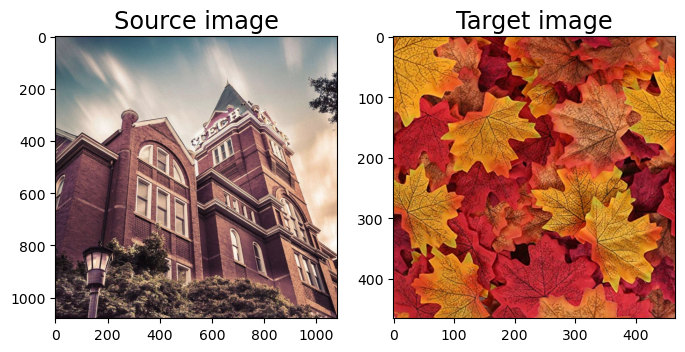

In [4]:
# Display these images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 20))
ax1.imshow(source_rgb)
ax1.set_title("Source image", size="xx-large")
ax2.imshow(target_rgb)
ax2.set_title("Target image", size="xx-large")
plt.show()

### Plot the distribution of color channels

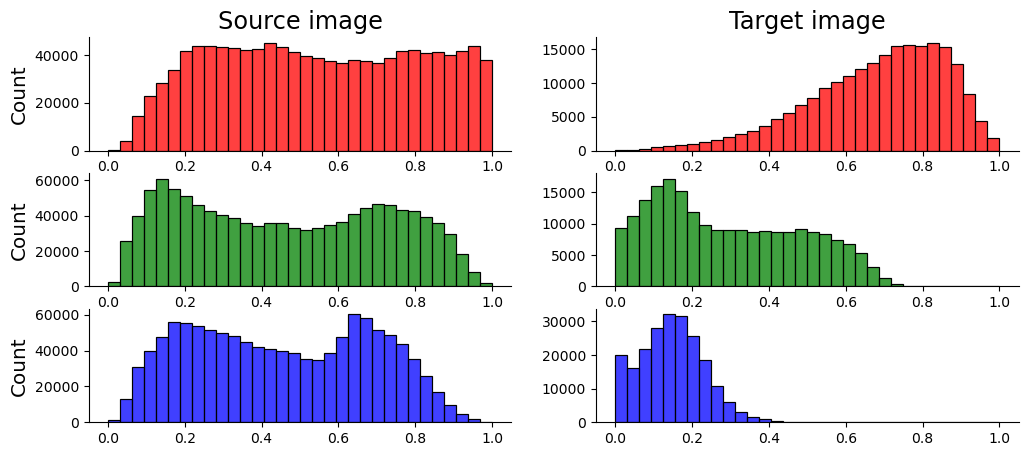

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(12, 5))
colors = ["red", "green", "blue"]
for i in range(3):
    sns.histplot(source_rgb[:, :, i].flatten(), color=colors[i], bins=32, ax=axes[i, 0], binrange=(0, 1))
    sns.histplot(target_rgb[:, :, i].flatten(), color=colors[i], bins=32, ax=axes[i, 1], binrange=(0, 1))
    axes[i, 1].set_ylabel("")
    axes[i, 0].set_ylabel("Count", size="x-large")
    sns.despine()
axes[0, 0].set_title("Source image", size="xx-large")
axes[0, 1].set_title("Target image", size="xx-large")
plt.show()

### Plot the source and target histograms and the cost matrix

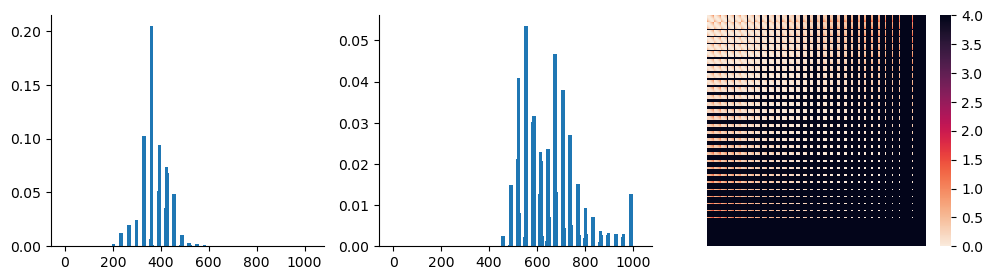

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# Plot source distribution
ax1.bar(np.arange(len(source_hist)), source_hist, width=15)
sns.despine(ax=ax1)

# Plot target distribution
ax2.bar(np.arange(len(target_hist)), target_hist, width=15)
sns.despine(ax=ax2)

# Plot cost matrix
sns.heatmap(C, cmap=sns.color_palette("rocket_r", as_cmap=True), ax=ax3)
ax3.set_xticks([]);
ax3.set_yticks([])

plt.show()

## Run a (P)OT agorithm

In [7]:
from ot_solvers import sinkhorn, apdagd

T_apdagd, _ = apdagd(source_hist.flatten(), target_hist.flatten(),
                     C, tol=5e-1, verbose=True, print_every=100,
                     check_termination=False, num_iters=500,
                     gamma=1e-2)

# T_sinkhorn, _ = sinkhorn(source_hist.flatten(), target_hist.flatten(),
#                          C, tol=5e-1, verbose=True, print_every=200,
#                          check_termination=False, num_iters=2000,
#                          gamma=1e-2)

Regularization parameter: gamma = 0.01
Tolerance for duality gap : 7.81e-03
Tolerance for ||Ax - b||_2: 7.81e-03
Iter =   100 | Duality gap = 5.93e-02 | ||Ax - b|| = 2.34e-02 | L estimate =   16.0
Iter =   200 | Duality gap = 2.59e-02 | ||Ax - b|| = 7.91e-03 | L estimate =   16.0
Iter =   300 | Duality gap = 1.27e-02 | ||Ax - b|| = 3.63e-03 | L estimate =   16.0
Iter =   400 | Duality gap = 7.39e-03 | ||Ax - b|| = 2.05e-03 | L estimate =   16.0
Iter =   500 | Duality gap = 4.82e-03 | ||Ax - b|| = 1.31e-03 | L estimate =   16.0


## Apply transport matrix to source image

In [8]:
from color_transfer import apply_transport

T = T_apdagd
cY, nY = apply_transport(T, Y=source_rgb, luvY=source_luv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


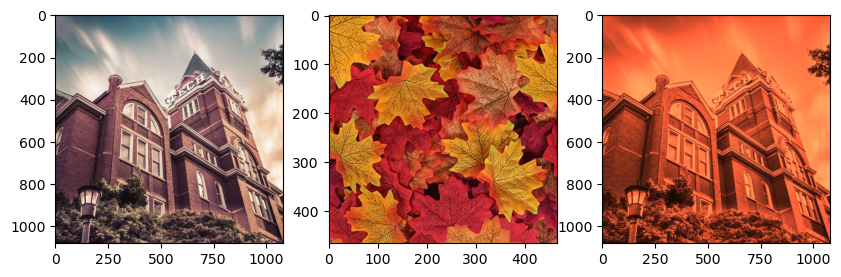

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 25))
ax1.imshow(source_rgb)
ax2.imshow(target_rgb)
ax3.imshow(nY)
plt.show()